## 공용 코드

In [1]:
# 파이썬
# ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 공통 모듈 임포트
import numpy as np
import pandas as pd
import os

# 깔끔한 그래프 출력을 위해 %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
# 이미지를 저장할 디렉토리 생성
os.makedirs(IMAGES_PATH, exist_ok=True)

# 이미지 저장
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

from matplotlib import font_manager, rc
import platform

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
    
    
mpl.rcParams['axes.unicode_minus'] = False
# Jupyter Notebook의 출력을 소수점 이하 3자리로 제한
%precision 3

# 그래픽 출력을 좀 더 고급화하기 위한 라이브러리
import seaborn as sns

# 과학 기술 통계 라이브러리
import scipy as sp
from scipy import stats

# 사이킷런 ≥0.20 필수
# 0.20 이상 버전에서 데이터 변환을 위한 Transformer 클래스가 추가됨
import sklearn
assert sklearn.__version__ >= "0.20"

# 노트북 실행 결과를 동일하게 유지하기 위해 시드 고정
# 데이터를 분할할 때 동일한 분할을 만들어 냄
np.random.seed(21)

In [4]:
# 데이터 가져오기
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# 28x28 크기의 이미지
mnist = fetch_openml('mnist_784', version = 1, as_frame = False)
mnist.target = mnist.target.astype(np.uint8)

X = mnist['data']
y = mnist['target']

X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape, X_test.shape)

C:\Users\USER\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(52500, 784) (17500, 784)


## 랜덤 PCA 와 점진적 PCA 의 시간 복잡도

In [11]:
## 훈련 데이터 가져오기

filename = './data//my_mnist/MNIST/raw/train-images.idx-ubyte'
m, n = X_train.shape

# memmap : filename 의 데이터를 메모리에 전부 로드한 것처럼 사용
# 실제로는 사용할 때 메모리에 로드함
# 메모리는 한정된 자원이기에 메모리 보다 더 큰 데이터를 가지고 훈련하는 경우에 사용
X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))

X_mm[:] = X_train
print(m, n) 
# 52500 784

52500 784


In [12]:
# 변수 지우기 - 메모리가 부족하면 gc 를 호출하는 것도 고려
del X_mm

X_mm = np.memmap(filename, dtype='float32', mode='readonly', shape=(m, n))

# 미니 배치의 크기 설정
# 배치의 크기는 필요에 따라 임의로 설정
# m 은 52500개이고 n_batches 는 100이므로 한 번에 525 개의 데이터를 불러옴
n_batches = 100
batch_size = m // n_batches

In [13]:
# 점진적 PCA 적용
from sklearn.decomposition import IncrementalPCA

# n_components 는 이전에서 찾았던 차원의 수
inc_pca = IncrementalPCA(n_components = 153, batch_size = batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, n_components=153)

In [17]:
# 랜덤 PCA
from sklearn.decomposition import PCA

# 일반 PCA 는 n_components 를 설정할 때 0 ~ 1 사이로 설정하면 분산의 비율
# 2 보다 큰 정수를 사용하면 주성분의 갯수가 됨
# 랜덤 PCA 는 정수로만 설정 가능
# 주성분의 갯수를 보고 가장 근사한 값을 찾아가는 방식이라서
# 주성분의 갯수가 먼저 결정되어야 함
rnd_pca = PCA(n_components = 153, svd_solver = 'randomized')
X_reduced = rnd_pca.fit_transform(X_train)
# 전진적 PCA 는 미니 배치를 이용하지만
# 랜덤 PCA 는 사용할 수 없어서 전체 데이터를 사용하므로
# 둘을 훈련하는데 사용하는 데이터가 다름

In [19]:
# 주성분의 개수에 따른 시간 복잡도

import time

for n_components in (2, 10, 153):
    print('주성분 갯수 :', n_components)
    
    # 3가지에 대한 PCA 를 모두 생성
    regular_pca = PCA(n_components = n_components, svd_solver = 'full')
    # 랜덤 PCA 는 주성분 갯수에 영향을 많이 받음
    rnd_pca = PCA(n_components = n_components, svd_solver = 'randomized', 
                  random_state = 21)
    # 점진적 PCA 는 데이터를 나누어 훈련하므로 데이터가 많거나 온라인 상황에 사용
    inc_pca = IncrementalPCA(n_components = n_components, batch_size = 500)
    
    # 시간 측정
    for pca in (regular_pca, rnd_pca, inc_pca):
        # t1 과 t2 사이의 시간을 측정
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print('class name :', pca.__class__.__name__, '시간 :', t2 - t1)
        
# 일반 PCA 는 3가지 경우 모두 시간이 비슷함
# 랜덤 PCA 는 가장 짧은 시간을 보이지만 주성분이 늘어남에 따라 급격하게 오래 걸림
# 점진적 PCA 는 전체적으로 시간이 오래 걸리지만 나누어서 학습이 가능
        

주성분 갯수 : 2
class name : PCA 시간 : 3.140089750289917
class name : PCA 시간 : 0.6995854377746582
class name : IncrementalPCA 시간 : 17.43005633354187
주성분 갯수 : 10
class name : PCA 시간 : 3.1304337978363037
class name : PCA 시간 : 0.8234667778015137
class name : IncrementalPCA 시간 : 18.14785361289978
주성분 갯수 : 153
class name : PCA 시간 : 3.3573644161224365
class name : PCA 시간 : 2.385624408721924
class name : IncrementalPCA 시간 : 20.497457265853882


In [25]:
# 데이터의 개수에 따른 시간 복잡도

import time

for n_samples in (1000, 2000, 3000, 4000, 5000, 10000):
    
    n_components = 2
    print('데이터의 갯수 :', n_samples)
    
    # 데이터의 수에 따라 샘플 데이터 생성
    X = np.random.randn(5000, n_samples)
    
    # 3가지에 대한 PCA 를 모두 생성
    regular_pca = PCA(n_components = n_components, svd_solver = 'full')
    rnd_pca = PCA(n_components = n_components, svd_solver = 'randomized', 
                  random_state = 21)
    inc_pca = IncrementalPCA(n_components = n_components, batch_size = 500)
    
    # 시간 측정
    for pca in (regular_pca, rnd_pca, inc_pca):
        t1 = time.time()
        pca.fit(X)
        t2 = time.time()
        print('class name :', pca.__class__.__name__, '시간 :', t2 - t1)

데이터의 갯수 : 1000
class name : PCA 시간 : 0.7699344158172607
class name : PCA 시간 : 0.0828855037689209
class name : IncrementalPCA 시간 : 1.6353015899658203
데이터의 갯수 : 2000
class name : PCA 시간 : 3.5080597400665283
class name : PCA 시간 : 0.13834691047668457
class name : IncrementalPCA 시간 : 2.3047823905944824
데이터의 갯수 : 3000
class name : PCA 시간 : 11.421747922897339
class name : PCA 시간 : 0.2258903980255127
class name : IncrementalPCA 시간 : 3.3968465328216553
데이터의 갯수 : 4000
class name : PCA 시간 : 32.493587017059326
class name : PCA 시간 : 0.29796457290649414
class name : IncrementalPCA 시간 : 4.349165916442871
데이터의 갯수 : 5000
class name : PCA 시간 : 47.413435220718384
class name : PCA 시간 : 0.37029409408569336
class name : IncrementalPCA 시간 : 6.41689920425415
데이터의 갯수 : 10000
class name : PCA 시간 : 111.25527715682983
class name : PCA 시간 : 0.786736249923706
class name : IncrementalPCA 시간 : 15.686268091201782


### 좋은 커널 과 gamma 값 찾기

In [28]:
# 데이터 가져오기 - 스위스 롤 사용

from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples = 1000, noise = 0.05, random_state = 21)
# t 는 연속형 숫자 데이터이기 때문에 분류에 사용할 수 없음
# 그래서 분류에 사용할 수 있는 bool 타입으로 변환
y = t > 6.9

# 데이터 확인
print(X[:5])
print(t[:5])
print(y[:5])

[[  2.307   0.631  -4.575]
 [  3.035   8.415   6.809]
 [  5.667  17.044 -10.103]
 [  0.91    4.588  -4.825]
 [  6.214   4.303   2.448]]
[ 5.172  7.437 11.507  4.916  6.653]
[False  True  True False False]


In [32]:
# 모델 훈련

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import KernelPCA

# 훈련 모델에 대한 파이프라인
clf = Pipeline([
    ('kpca', KernelPCA(n_components = 2)),
    ('log_reg', LogisticRegression(solver = 'lbfgs')),
])

# 파라미터 - gamma 값과 사용할 kernel 종류
# 위에서 사용한 kpca 에 대해 gamma, kernel 을 적용하는 것이므로
# 이름을 통일시켜야 함
# log_reg 에 대해 적용하고 싶으면 log_reg__gamma 형식
param_grid = [{
    'kpca__gamma' : np.linspace(0.03, 0.05, 10),
    'kpca__kernel' : ['rbf', 'sigmoid']
}]

grid_search = GridSearchCV(clf, param_grid, cv = 3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03 , 0.032, 0.034, 0.037, 0.039, 0.041, 0.043, 0.046, 0.048,
       0.05 ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [33]:
# 최적의 파라미터 확인

print(grid_search.best_params_)

{'kpca__gamma': 0.034444444444444444, 'kpca__kernel': 'rbf'}


### PCA 를 이용한 잡음 제거

In [34]:
# 숫자 이미지 데이터 가져오기
from sklearn.datasets import load_digits

digits = load_digits() 
digits.data.shape # 8x8 크기의 데이터

(1797, 64)

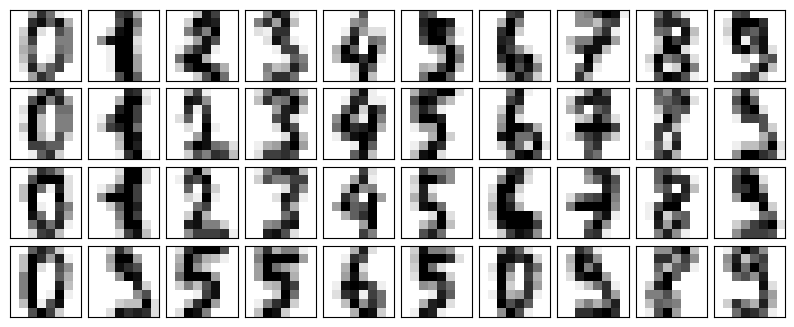

In [39]:
# 이미지 출력 함수
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                subplot_kw={'xticks':[], 'yticks':[]},
                gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                 cmap = 'binary', interpolation = 'nearest', clim = (0, 16))

# 원본 이미지 출력        
plot_digits(digits.data)

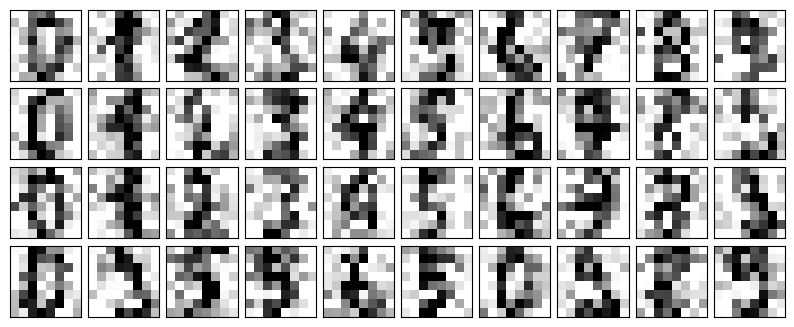

In [40]:
# 데이터에 잡음 추가
np.random.seed(21)
noisy = np.random.normal(digits.data, 4)

# 잡음 추가 결과 확인
plot_digits(noisy)

36


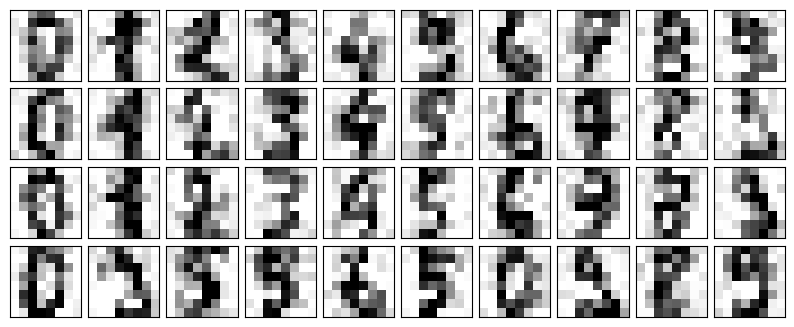

In [44]:
# PCA 를 수행해서 잡음 제거 - 분산 비율 사용
# PCA 를 사용해서 훈련하고 복원

pca = PCA(n_components = 0.8).fit(noisy)
# 주성분 갯수 확인
print(pca.n_components_) # 36개의 주성분 사용

# 잡음이 섞인 이미지에 주성분 분석을 수행
components = pca.transform(noisy)
# 주성분 분석 결과를 가지고 이미지 복원
filtered = pca.inverse_transform(components)

# 결과 확인
plot_digits(filtered)